In [2]:
show_plots = True

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from quetzal.model import stepmodel
from quetzal.io.display import all_pt_paths, path, pt_path
%matplotlib inline

SQLalchemy is not installed. No support for SQL output.


In [4]:
# Load the network model from the last exercise
model_path = '../../model/'
sm = stepmodel.read_json(model_path + 'network')

In [93]:
# check for broken GeoDataFrames
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
print("Fixing:", broken_gdf_keys)
# fix broken GeoDataFrames
for key in broken_gdf_keys:
    sm.__dict__[key] = gpd.GeoDataFrame(sm.__dict__[key], crs=sm.epsg)
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
if len(broken_gdf_keys)>0:
    print("Broken GeoDataFrames:",broken_gdf_keys)
else:
    print("Successfully fixed.")

Fixing: ['checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters']
Successfully fixed.


In [7]:
sm.__dict__.keys()

dict_keys(['parameters', 'debug', 'walk_on_road', 'coordinates_unit', 'epsg', 'segments', 'checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters', 'fare_rules', 'fare_attributes', 'mode_nests', 'logit_scales', 'utility_values', 'jsons', 'dead_ends', 'circular_lines', 'broken_sequences'])

In [23]:
sm.nodes

,geometry
index,
n_588,POINT (13.36802 52.42440)
n_693,POINT (13.47742 52.62032)
n_475,POINT (13.29844 52.51853)
n_708,POINT (13.14916 52.54143)
n_685,POINT (13.33293 52.60926)
...,...
n_24,POINT (13.46048 52.50061)
n_497,POINT (13.58026 52.48472)
n_589,POINT (13.42147 52.53765)


In [94]:
# How many zones do we have?
len(sm.zones)

448

## Preparation of OD-times

The pathfinders need a column "time" in the links or road_links tables to find the shortest paths. The PT pathfinder also applies a generalized boarding time (can be interpreted as a penalty for interchanging between transport carriers) and a waiting time, which is computed from the headway of PT carriers (waiting time equals half the headway (in seconds) assuming a randomly and evenly distributed arrival pattern of passengers on every PT stop).

In [95]:
sm.road_links.sample(1)

,a,b,length,validation_load,validation_share,geometry,highway,maxspeed,validation_threshold
index,,,,,,,,,
132747,30436662,4621449318,11.61,9149.904837,0.897811,"LINESTRING (13.31749 52.58870, 13.31764 52.58865)",residential,None,False


In [96]:
sm.links.sample(1)

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,...,route_type,route_color,disaggregated_a,disaggregated_b,road_a,road_b,road_length,geometry,road_node_list,road_link_list
index,,,,,,,,,,,,,,,,,,,,,
link_656,10170_109_1,n_187,n_751,9,102.0,600,10170_109_1,10170_109,932,0,...,rail,None,node_de:11000:900120004:2:53,node_de:11000:900120005:5:58,29785481,252778554,NaN,"LINESTRING (13.45045 52.50390, 13.43614 52.51069)",[],[]


In [97]:
# We don't see any length column in our links,
# but it is nice for calculating speeds and for later steps.
# We can cast the PT network onto the road network (as in A40)
# Start with the bus links
bus = sm.copy() # copy the whole model
bus.links = bus.links.loc[bus.links['route_type'].isin(['bus'])] # Filter
# Apply quetzal's casting function
bus.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=5, 
    n_neighbors=5, 
    penalty_factor=2,
    replace_nodes=False
)

22609_700_0: 100%|██████████| 369/369 [01:11<00:00,  5.14it/s]


In [98]:
bus.links.sample()

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,...,route_type,route_color,disaggregated_a,disaggregated_b,road_a,road_b,road_node_list,road_link_list,road_length,geometry
index,,,,,,,,,,,,,,,,,,,,,
link_4626,17335_700_1,n_188,n_453,7,60.0,1200,17335_700_1,17335_700,932,1,...,bus,None,node_de:11000:900081203::1,node_de:11000:900081255::2,29769518,35126701,"[29769518, 31354898, 31354897, 35125470, 35125...","[95778, 95773, 98872, 98875, 98880, 98883, 988...",1138.003,"LINESTRING (13.43785 52.42181, 13.43826 52.419..."


In [99]:
# Now take the road_length of casted model as the length of our genuine model
sm.links['length'] = np.nan # create a new column with default values
sm.links.loc[sm.links['route_type'].isin(['bus']),
             'length'] = bus.links['road_length']

In [100]:
# For rail links, we can assign the geometric distance
sm.links.loc[sm.links['length'].isna(), 'length'] = \
    sm.links.loc[sm.links['length'].isna(), 'geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))
# Take the geometric line and from it the start and end points, then calculate the meter distance in between

In [101]:
# You can calculate the average bus operation speed
bus = sm.links.loc[sm.links['route_type'] == 'bus'] # filter
bus_lines = bus.groupby('route_id')[['time', 'length']].sum() # sum up time and length for each route
bus_speed = bus['length'].sum() / bus['time'].sum() # operation speed
print('bus_speed =', bus_speed, 'm / s')

bus_speed = 10.639783415885594 m / s


In [102]:
sm.road_links.head(3)

,a,b,length,validation_load,validation_share,geometry,highway,maxspeed,validation_threshold
index,,,,,,,,,
1,172539,34694265,237.653,10379.796248,1.0,"LINESTRING (13.33550 52.56521, 13.33859 52.56428)",tertiary,50,True
2,172539,34694336,687.484,13820.164605,1.0,"LINESTRING (13.33550 52.56521, 13.34515 52.56680)",secondary,50,True
3,172539,3977742457,391.153,19240.567732,1.0,"LINESTRING (13.33550 52.56521, 13.33114 52.56289)",secondary,50,True


#### fixing broken 'maxspeed' column as it contains None, strings not convertable to numbers and lists 

In [103]:
y = 0
a = [item for sublist in \
        [item for sublist in \
            [[[x for n, x in a1 if not x in a2[:n]] \
                for a1, a2 in [(enumerate(sm.road_links['maxspeed'].values[y:y+len(sm.road_links)//1000]), sm.road_links['maxspeed'].values[y:y+len(sm.road_links)//1000])]] \
            for y in np.array(range(len(sm.road_links)//1000+1))*1000]\
        for item in sublist]\
    for item in sublist]

In [104]:
allHighwayTypes = []

for val in sm.road_links['highway'].values:
    if type(val)==list:
        for v in val:
            if not v in allHighwayTypes:
                allHighwayTypes.append(v)
    elif not val in allHighwayTypes:
        allHighwayTypes.append(val)

print(allHighwayTypes)


['tertiary', 'secondary', 'residential', 'primary', 'primary_link', 'motorway_link', 'motorway', 'unclassified', 'secondary_link', 'trunk_link', 'living_street', 'trunk', 'tertiary_link', 'razed']


In [105]:
realisticSpeedDict={30: 25, 100: 70}
speedReduction = .7

In [106]:
non_valid_speed_str = [None, 'walk','DE:urban']
maxspeed_clean = np.asarray([np.asarray(x).astype(int).mean() if type(x) == list else int(x) for x in sm.road_links['maxspeed'].values if x not in non_valid_speed_str])

maxSpeedByType = {}
effectiveSpeedByType = {}
for key in allHighwayTypes:
    fltrd = maxspeed_clean[[key in x if type(x)==list else x==key for x, y in zip(sm.road_links['highway'].values, sm.road_links['maxspeed'].values) if y not in non_valid_speed_str]]
    if len(fltrd)>0:
        maxSpeedByType[key] = round(fltrd.astype(int).mean(),2)
        effectiveSpeedByType[key] = maxSpeedByType[key]*speedReduction
    else:     
        maxSpeedByType[key] = 0.1
        effectiveSpeedByType[key] = 0.1
maxSpeedByType

{'tertiary': 45.48,
 'secondary': 47.9,
 'residential': 30.68,
 'primary': 48.54,
 'primary_link': 48.14,
 'motorway_link': 56.78,
 'motorway': 75.58,
 'unclassified': 40.28,
 'secondary_link': 48.88,
 'trunk_link': 48.0,
 'living_street': 25.69,
 'trunk': 51.67,
 'tertiary_link': 47.19,
 'razed': 0.1}

In [107]:
maxspeed_cleaned = np.asarray([np.asarray(mxsp).astype(int).mean()*speedReduction if type(mxsp) == list \
    else np.asarray([effectiveSpeedByType[h] for h in hw]).mean() if type(hw)==list \
    else effectiveSpeedByType[hw] if mxsp in non_valid_speed_str \
    else np.float64(mxsp)*speedReduction \
for hw,mxsp in zip(sm.road_links['highway'].values, sm.road_links['maxspeed'].values)])

sm.road_links['avspeed'] = maxspeed_cleaned

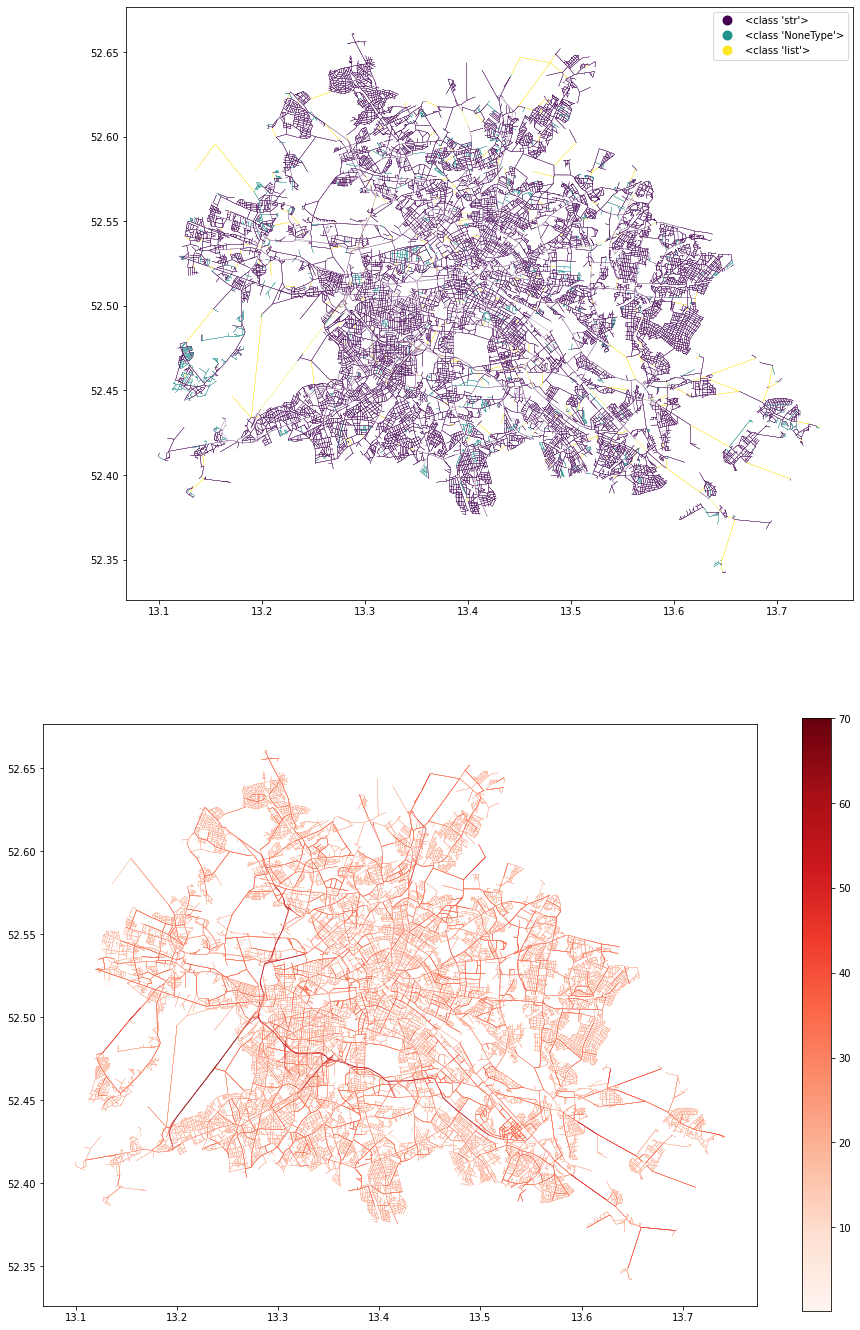

In [108]:
if show_plots:
    fig, ax = plt.subplots(nrows=2, figsize = (16,24))
    sm.road_links.plot(ax=ax.flat[0], cmap="viridis", column=np.array([type(x) for x in sm.road_links['maxspeed']]), linewidth=0.2, legend=True)
    sm.road_links.plot(ax=ax.flat[1], cmap="Reds", column=maxspeed_cleaned, linewidth=(maxspeed_cleaned/100), legend=True)

In [109]:
# Create the time LoS column for cars (it's already there for PT from the GTFS feeds)
# car_speed = bus_speed * 1.25
# sm.road_links['time'] = sm.road_links['length'] / car_speed # m/s
sm.road_links['time'] = sm.road_links['length'] / (sm.road_links['avspeed'] *1000/(60**2))

In [110]:
max(sm.road_links['length']/sm.road_links['time']*3.6)

70.0

In [111]:
max(sm.road_links['length']/sm.road_links['time']*3.6)

70.0

<AxesSubplot:>

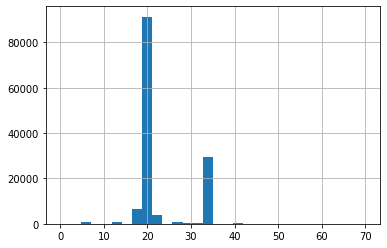

In [112]:
r = sm.road_links['length']/sm.road_links['time']*3.6
r.hist(bins=30)

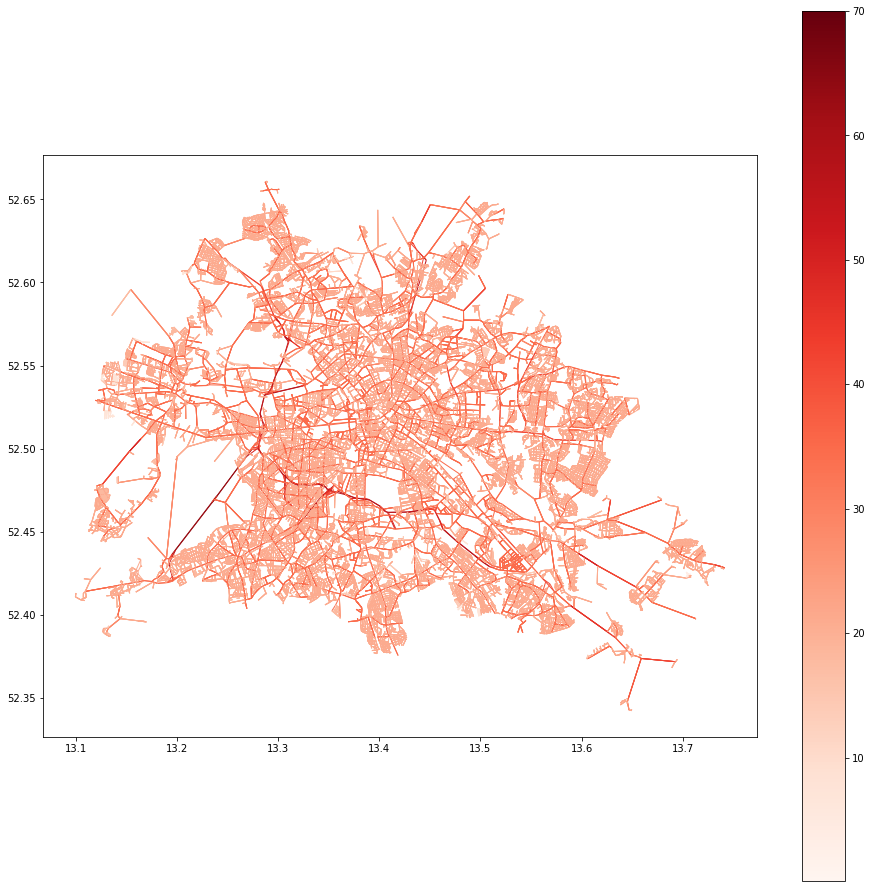

In [113]:
if show_plots:
    fig, ax = plt.subplots(nrows=1, figsize = (16,16))
    sm.road_links.plot(ax=ax, cmap="Reds", column=sm.road_links['length']/sm.road_links['time']*3.6, linewidth=1, legend=True)

In [114]:
# If we want to compute walking paths on road links, we need a time for that to
# sm.road_links['walk_time'] = sm.road_links['time'] * 3 # walk three times slower than car
sm.road_links['walk_time'] = sm.road_links['length'] / (5/3.6) # walk with 5 km/h per hour
# sm.road_links['bike_time'] = sm.road_links['length'] / (16.5/3.6) #
print('walk_speed', bus_speed * 1.25 / 3 *3.6, 'km/h seems too fast.')

walk_speed 15.959675123828392 km/h seems too fast.


## Pathfinding

Next, we want to create a table of OD-relations for different modes, each, being representative for the performance of a specific mode on a specific OD pair.

Quetzal has multiple options for path finding, seperated into one function wrapper for road and one for PT. They create the `car_los` and `pt_los tables`, respectively.

For road transport, quetzal can simply compute one shortest path per OD pair or multiple ones if you had the capacities and volumes already saved in the model (comes from the assignment step at the very end). So, we just compute one path for now (`all_or_nothing=True`)

The PT pathfinder has two relevant attributes: `broken_modes` and `broken_routes`. If both are `False`, the pathfinder just searches for the shortest path between every OD pair, considering all PT modes and routes. If `broken_modes=True`, the pathfinder searches shortest paths for every possible mode combination. If `broken_routes=True`, the pathfinder searches shortest paths for every possible route combination. 
Additionally you can decide whether walking connections shall be done on roadsides or not with the `walk_on_road` parameter (question of computation time).

### Car

In [115]:
sm.zone_to_road.head()
# change time variable to-do, eggress

,a,b,rank,distance,direction,speed_factor,short_leg_speed,long_leg_speed,speed,time,walk_time,geometry
index,,,,,,,,,,,,
ztr_0,zone_01011101,26704103,0,79.059362,access,0.628726,3,7,3.000000,94.871235,94.871235,"LINESTRING (13.34749 52.50644, 13.34769 52.50715)"
ztr_1,zone_01011102,4685580870,0,368.127113,access,1.356700,3,7,4.070101,325.608060,325.608060,"LINESTRING (13.35580 52.51386, 13.35462 52.51710)"
ztr_2,zone_01011103,388310225,0,60.982482,access,0.552189,3,7,3.000000,73.178978,73.178978,"LINESTRING (13.35870 52.50350, 13.35958 52.50339)"
ztr_3,zone_01011104,26765676,0,58.122822,access,0.539086,3,7,3.000000,69.747386,69.747386,"LINESTRING (13.36822 52.50211, 13.36785 52.50258)"
ztr_4,zone_01011105,26870023,0,65.752624,access,0.573379,3,7,3.000000,78.903149,78.903149,"LINESTRING (13.36617 52.50796, 13.36699 52.50764)"


In [116]:
# Simple road pathfinder # broken_modes=False, broken_routes=False
sm.step_road_pathfinder(all_or_nothing=True)

In [117]:
len(sm.car_los)

200704

In [118]:
sm.car_los.sample()

,origin,destination,time,path,node_path,link_path,ntlegs
191838,zone_12214423,zone_03061227,1157.559022,"[zone_12214423, 29691332, 27177321, 27177322, ...","[29691332, 27177321, 27177322, 530319, 1883829...","[80113, 80117, 73559, 108051, 41711, 8957, 24,...","[(zone_12214423, 29691332), (29419172, zone_03..."


In [119]:
# Assign a length to LoS table
# Create a dictionary of road link lengths
len_dict = sm.road_links['length'].to_dict()
# Apply it to the link path column (sum up all links for each path)
sm.car_los['length'] = sm.car_los['link_path'].apply(
    lambda l: sum([len_dict[i] for i in l]))

In [120]:
# add the route type for sake of consistency
sm.analysis_car_route_type()

In [121]:
sm.car_los.sample()

,origin,destination,time,path,node_path,link_path,ntlegs,length,route_types,route_type
187782,zone_12103116,zone_03020203,1192.537486,"[zone_12103116, 29490316, 27199808, 27199807, ...","[29490316, 27199808, 27199807, 27199806, 25904...","[80420, 80418, 80416, 111988, 133513, 71209, 9...","[(zone_12103116, 29490316), (254446515, zone_0...",7727.827,"(car,)",car


### Bike

In [122]:
bk = sm.copy()
bk.zone_to_road.head()
# change time variable to-do, eggress

,a,b,rank,distance,direction,speed_factor,short_leg_speed,long_leg_speed,speed,time,walk_time,geometry
index,,,,,,,,,,,,
ztr_0,zone_01011101,26704103,0,79.059362,access,0.628726,3,7,3.000000,94.871235,94.871235,"LINESTRING (13.34749 52.50644, 13.34769 52.50715)"
ztr_1,zone_01011102,4685580870,0,368.127113,access,1.356700,3,7,4.070101,325.608060,325.608060,"LINESTRING (13.35580 52.51386, 13.35462 52.51710)"
ztr_2,zone_01011103,388310225,0,60.982482,access,0.552189,3,7,3.000000,73.178978,73.178978,"LINESTRING (13.35870 52.50350, 13.35958 52.50339)"
ztr_3,zone_01011104,26765676,0,58.122822,access,0.539086,3,7,3.000000,69.747386,69.747386,"LINESTRING (13.36822 52.50211, 13.36785 52.50258)"
ztr_4,zone_01011105,26870023,0,65.752624,access,0.573379,3,7,3.000000,78.903149,78.903149,"LINESTRING (13.36617 52.50796, 13.36699 52.50764)"


In [123]:
# road network excluding high ways etc.
bk.road_links = bk.road_links[bk.road_links['avspeed']/0.7 <= 50]

bk.road_links.head()
# sm.bike_los = sm.car_los.copy()
# change speed...
# restrict to roads...


,a,b,length,validation_load,validation_share,geometry,highway,maxspeed,validation_threshold,avspeed,time,walk_time,index
index,,,,,,,,,,,,,
1,172539,34694265,237.653,10379.796248,1.000000,"LINESTRING (13.33550 52.56521, 13.33859 52.56428)",tertiary,50,True,35.0,24.444309,171.11016,1
2,172539,34694336,687.484,13820.164605,1.000000,"LINESTRING (13.33550 52.56521, 13.34515 52.56680)",secondary,50,True,35.0,70.712640,494.98848,2
3,172539,3977742457,391.153,19240.567732,1.000000,"LINESTRING (13.33550 52.56521, 13.33114 52.56289)",secondary,50,True,35.0,40.232880,281.63016,3
4,172545,271370539,17.179,12033.495869,0.881115,"LINESTRING (13.34661 52.56703, 13.34664 52.56688)",tertiary,50,False,35.0,1.766983,12.36888,4
5,172545,28345515,171.849,9612.436767,1.000000,"LINESTRING (13.34661 52.56703, 13.34681 52.56857)",tertiary,50,True,35.0,17.675897,123.73128,5


In [124]:
bk.road_links['time'] = bk.road_links['length'] / (16.5/3.6)
bk.road_links['time'] 

index
1          51.851564
2         149.996509
3          85.342473
4           3.748145
5          37.494327
             ...    
135440     19.221164
135441     46.208509
135442     13.385018
135443     42.845891
135444     24.631418
Name: time, Length: 134700, dtype: float64

In [125]:
# Simple road pathfinder # broken_modes=False, broken_routes=False
bk.step_road_pathfinder(all_or_nothing=True)

In [126]:
# Assign a length to LoS table
# Create a dictionary of road link lengths
len_dict = bk.road_links['length'].to_dict()
# Apply it to the link path column (sum up all links for each path)
bk.car_los['length'] = bk.car_los['link_path'].apply(
    lambda l: sum([len_dict[i] for i in l]))

In [127]:
# add the route type for sake of consistency
bk.analysis_car_route_type()
bk.car_los['route_type'] = 'bike'
bk.car_los['route_types'] = [('bike',) for x in range(len(bk.car_los))]

In [128]:
bk.car_los.sample()

,origin,destination,time,path,node_path,link_path,ntlegs,length,route_types,route_type
104712,zone_06030610,zone_09020601,4116.198246,"[zone_06030610, 487188737, 27452641, 59684211,...","[487188737, 27452641, 59684211, 59684218, 2745...","[81839, 100706, 100711, 81825, 81828, 118115, ...","[(zone_06030610, 487188737), (3356581523, zone...",18220.55,"(bike,)",bike


### PT

In [129]:
# Simple PT
sm.step_pt_pathfinder(broken_modes=True, broken_routes=False, walk_on_road=False)

path_analysis: 100%|██████████| 1795069/1795069 [04:50<00:00, 6189.74it/s] 


In [130]:
# append bike type to pt_los
sm.pt_los.append(bk.car_los)

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path,time,length,route_types,route_type
0,zone_01011101,zone_01011101,0.000000,"(zone_01011101,)",False,mode_breaker,"{subway, bus, tram, rail}",[],[],[],...,[],[],True,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,zone_01011101,zone_01011102,792.010207,"(zone_01011101, n_496, zone_01011102)",False,mode_breaker,"{subway, bus, tram, rail}",[],[],[n_496],...,[],[],True,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,zone_01011101,zone_01011103,734.167399,"(zone_01011101, n_496, zone_01011103)",False,mode_breaker,"{subway, bus, tram, rail}",[],[],[n_496],...,[],[],True,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,zone_01011101,zone_01011104,1670.059376,"(zone_01011101, n_138, n_381, zone_01011104)",False,mode_breaker,"{subway, bus, tram, rail}",[],[],"[n_138, n_381]",...,[],[],True,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,zone_01011101,zone_01011105,1867.161484,"(zone_01011101, n_138, n_381, zone_01011105)",False,mode_breaker,"{subway, bus, tram, rail}",[],[],"[n_138, n_381]",...,[],[],True,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200699,zone_12304314,zone_12302110,NaN,"[zone_12304314, 30437288, 30437287, 30437286, ...",NaN,NaN,NaN,NaN,NaN,"[30437288, 30437287, 30437286, 30437285, 30437...",...,NaN,NaN,NaN,NaN,NaN,NaN,1308.921690,5391.281,"(bike,)",bike
200700,zone_12304314,zone_12302211,NaN,"[zone_12304314, 30437288, 30437287, 30437286, ...",NaN,NaN,NaN,NaN,NaN,"[30437288, 30437287, 30437286, 30437285, 30437...",...,NaN,NaN,NaN,NaN,NaN,NaN,908.882340,3533.546,"(bike,)",bike
200701,zone_12304314,zone_12302212,NaN,"[zone_12304314, 30437288, 30437287, 30437286, ...",NaN,NaN,NaN,NaN,NaN,"[30437288, 30437287, 30437286, 30437285, 30437...",...,NaN,NaN,NaN,NaN,NaN,NaN,730.142128,2938.288,"(bike,)",bike
200702,zone_12304314,zone_12304313,NaN,"[zone_12304314, 7444729078, 4892922989, 280323...",NaN,NaN,NaN,NaN,NaN,"[7444729078, 4892922989, 280323089, 27466430, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,727.506002,2520.483,"(bike,)",bike


In [131]:
len(sm.pt_los)

1795069

In [132]:
sm.pt_los.sample()

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,link_path,footpaths,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path
13007,zone_01022207,zone_01011401,1580.057372,"(zone_01022207, n_678, link_463, link_464, lin...",False,mode_breaker,{tram},"[n_678, n_298]","[n_298, n_546]","[n_678, n_298, n_546]","[link_463, link_464, link_465, link_12009]",[],"[(zone_01022207, n_678), (n_546, zone_01011401)]",[n_298],"[link_463, link_12009]","[link_465, link_12009]",False,1,396.0,6810.0


In [133]:
sm.pt_los.columns

Index(['origin', 'destination', 'gtime', 'path', 'reversed',
       'pathfinder_session', 'broken_modes', 'boardings', 'alightings',
       'node_path', 'link_path', 'footpaths', 'ntlegs', 'transfers',
       'boarding_links', 'alighting_links', 'all_walk', 'ntransfers',
       'time_link_path', 'length_link_path'],
      dtype='object')

In [134]:
sm.links['route_type'].unique()

array(['bus', 'rail', 'tram', 'subway'], dtype=object)

In [135]:
# Add route types to the paths
# The mode that appears first in the hierarchy is assigned as
# main mode, if there is more than one route_type used on the path
hierarchy = ['rail', 'subway', 'funicular', 'tram', 'bus']
sm.analysis_pt_route_type(hierarchy)

array([[<AxesSubplot:title={'center':'ntransfers'}>]], dtype=object)

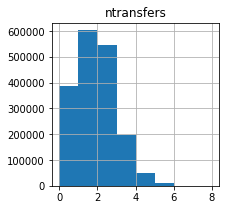

In [136]:
# How many transfers do we have?
sm.pt_los.hist(column='ntransfers', bins=sm.pt_los['ntransfers'].max(), figsize=(3,3))

<AxesSubplot:xlabel='route_types'>

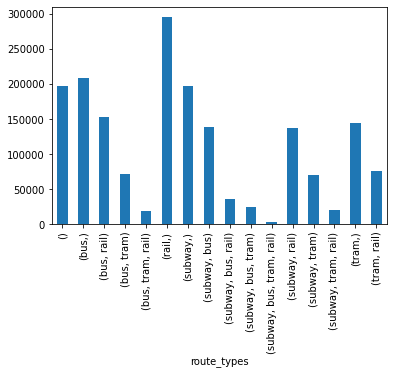

In [137]:
# How many connections do we have per mode combination in the shortest paths?
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple) # bugfix
sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

In [138]:
# Now, let's look at the results when we disaggregate paths by route_type
sm.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=False)

path_analysis: 100%|██████████| 200704/200704 [00:04<00:00, 42073.88it/s]


In [139]:
# How many paths do we have now compared to 12,100 before?
len(sm.pt_los)

200704

In [140]:
sm.analysis_pt_route_type(hierarchy)
sm.pt_los.sample()

,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,...,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path,route_types,route_type
61636,zone_04030931,zone_07040406,2214.134861,"(zone_04030931, n_392, link_10989, link_10991,...",best_path,False,[n_392],[n_606],"[n_392, n_606]","[link_10989, link_10991, link_10995, link_1099...",...,"[(zone_04030931, n_392), (n_606, zone_07040406)]",[],[link_10989],[link_11009],False,0,1260.0,12877.427,"(bus,)",bus


<AxesSubplot:xlabel='route_types'>

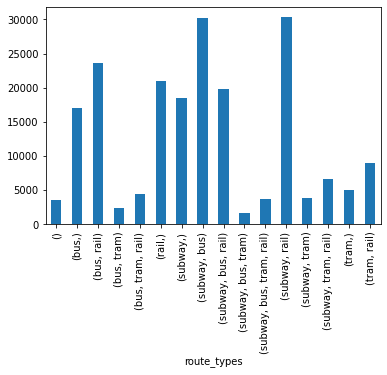

In [141]:
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple) # bugfix
sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

array([[<AxesSubplot:title={'center':'ntransfers'}>]], dtype=object)

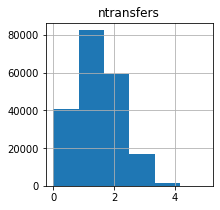

In [142]:
# How many transfers do we have?
sm.pt_los.hist(column='ntransfers', bins=6, figsize=(3,3))

In [143]:
# Compute time attribute (from link path and footpaths and access links)
sm.analysis_pt_time()

In [144]:
# Closer look at one OD pair
sm.pt_los.loc[(sm.pt_los['origin']=='zone_11') & (sm.pt_los['destination']=='zone_99')][
    ['route_types', 'time', 'ntransfers']]

,route_types,time,ntransfers


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


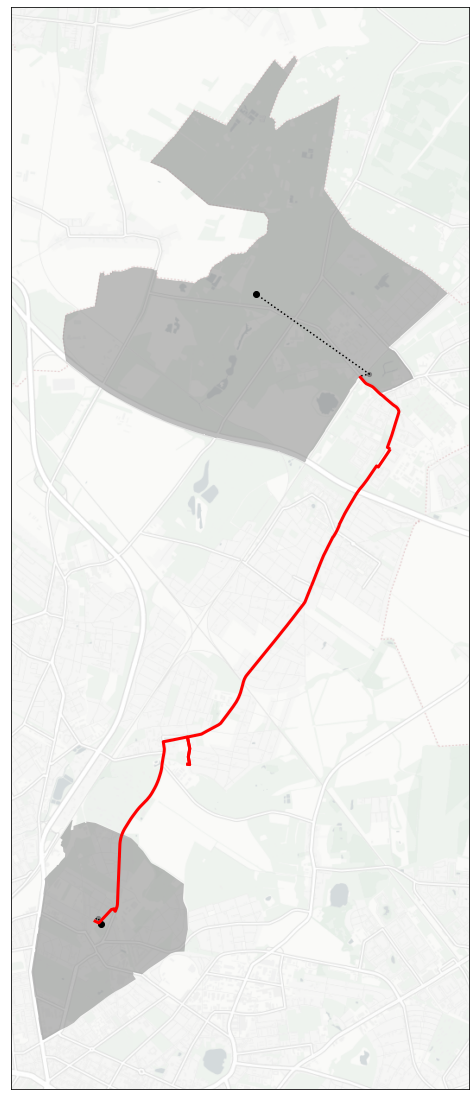

In [145]:
# Plot
if show_plots:
    plot = sm.change_epsg(3857, coordinates_unit=sm.coordinates_unit)
    plot.links['color'] = '#' + plot.links['route_color']
    fig, axes = plot.plot_separated_paths(
        sm.zones.index[77%len(sm.zones)], sm.zones.index[67%len(sm.zones)], rows=1, figsize=[16, 16],
        title=None, constrained_layout=True, zoom=13, resize=True,
        basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png', 
    )

In [146]:
# Assign a length to LoS table
sm.analysis_pt_length()

<AxesSubplot:>

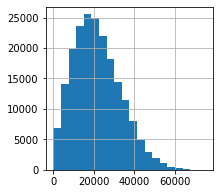

In [147]:
# Length distribution
sm.pt_los['length'].hist(bins=20, figsize=(3,3))

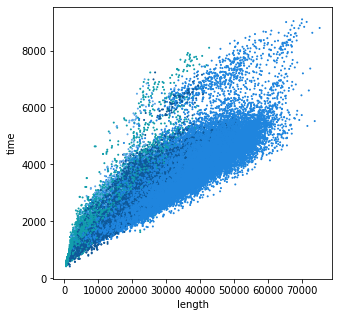

In [148]:
# Dependency between distance and time
mask = sm.pt_los['origin']!=sm.pt_los['destination'] # Filter statement
color_dict = {'bus': '#129eac', 'subway': '#0e5899', 'tram': '#5ea8e8', 'rail': '#1F85DE', 'walk': '#adb3b4'}
color_list = [color_dict[t] for t in sm.pt_los.loc[mask, 'route_type']]
ax = sm.pt_los.loc[mask].plot(
    kind='scatter', x='length', y='time', figsize=[5, 5], s=1, c=color_list)

In [149]:
# Plot all paths between zones including car
if show_plots: path(sm, sm.zones.index[77%len(sm.zones)], sm.zones.index[67%len(sm.zones)], public=True, private=True)

## Prices

Add price LoS attribute to LoS tables

In [150]:
sm.car_los.head()

,origin,destination,time,path,node_path,link_path,ntlegs,length,route_types,route_type
0,zone_01011101,zone_01011101,0.000000,[zone_01011101],[],[],[],0.000,"(car,)",car
1,zone_01011101,zone_01011102,515.416152,"[zone_01011101, 26874394, 26745299, 26874397, ...","[26874394, 26745299, 26874397, 26703656, 26703...","[7686, 4937, 7690, 2681, 2675, 2678, 69015, 69...","[(zone_01011101, 26874394), (1437259263, zone_...",1163.927,"(car,)",car
2,zone_01011101,zone_01011103,378.909144,"[zone_01011101, 26704698, 26704700, 26704702, ...","[26704698, 26704700, 26704702, 103553865, 2682...","[2987, 2994, 2995, 38010, 6654, 38012, 6657, 6...","[(zone_01011101, 26704698), (26765651, zone_01...",1099.488,"(car,)",car
3,zone_01011101,zone_01011104,423.158481,"[zone_01011101, 26704698, 26704700, 26704702, ...","[26704698, 26704700, 26704702, 103553865, 2682...","[2987, 2994, 2995, 38010, 6654, 38012, 6657, 6...","[(zone_01011101, 26704698), (26765676, zone_01...",1677.885,"(car,)",car
4,zone_01011101,zone_01011105,346.622563,"[zone_01011101, 26874394, 26745299, 26874397, ...","[26874394, 26745299, 26874397, 26703656, 26703...","[7686, 4937, 7690, 2681, 2676, 120519, 75470, ...","[(zone_01011101, 26874394), (162070841, zone_0...",1724.303,"(car,)",car


In [151]:
# Car usage has operating cost of 12ct/km in average
# Note: we don't apply sunk cost like maintenance or purchase cost
sm.car_los['price'] = sm.car_los['length'] * 0.12 / 1000

In [152]:
# For PT, we have a look at the PT operators price structure.
# For this toy model we simplify it to day tickets:
# https://www.ratp.fr/en/titres-et-tarifs/mobilis
# Assume that a passenger makes two trips per day with a day ticket
sm.pt_los['price'] = 7.5 / 2
# We don't re-build the exact price structure, but make longer trips more expensive
sm.pt_los.loc[sm.pt_los['length']>10000, 'price'] = 10 / 2

In [153]:
sm.pt_los.sample()

,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,...,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,access_length,footpath_length,in_vehicle_length,length,price
126239,zone_08010118,zone_09051901,2642.641443,"(zone_08010118, n_106, link_730, link_731, lin...",best_path,False,"[n_106, n_397]","[n_397, n_720]","[n_106, n_397, n_720]","[link_730, link_731, link_732, link_733, link_...",...,0.0,972.0,900.0,0,2642.641443,1031.09356,0.0,19757.0,20788.09356,5.0


## Save model

In [154]:
sm.pt_los.reset_index(drop=True, inplace=True)

In [155]:
sm.to_json(model_path + 'los_tables')

to_hdf(overwriting):  87%|████████▋ | 33/38 [01:23<00:02,  1.77it/s]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes
could not save geometry from table mode_nests
could not save geometry from table logit_scales
could not save geometry from table utility_values


to_hdf(overwriting): 100%|██████████| 38/38 [01:55<00:00,  3.04s/it]
